# Load libraries

In [1]:
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scipy.io as io
from scipy.sparse import csr_matrix
import logging
import os
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import math
import gc
import random
from sklearn.utils import shuffle
import combat
import patsy
logging.basicConfig(level=logging.INFO)
savepath = 'Lupus_study_adjusted_V3.h5ad'
nonormpath = 'Lupus_study_nonorm.h5ad'

# Read data

In [2]:
%matplotlib inline
##################
# Configure file #
##################
sc.settings.verbosity = 2
sc.settings.autoshow = False
sc.settings.set_figure_params(dpi=100, dpi_save=300, format='png', frameon=False, transparent=True, fontsize=16)
plt.rcParams["image.aspect"] = "equal"
adata = sc.read(savepath, cache=True)
print('Processed dataset: {}'.format(adata))
figdir = "./figures."
sc.settings.figdir = "./figures."
MASTERCOLORS = sc.pl.palettes.default_64
MASTERCOLORS.remove("#FEFFE6")
MASTERCOLORS.remove("#FFFF00")


Processed dataset: AnnData object with n_obs × n_vars = 912434 × 1000 
    obs: 'Broad', 'CD127|IL7R|j95-27|pAbO', 'CD14|CD14|j95-20|pAbO', 'CD161|KLRB1|j95-11|pAbO', 'CD183|CXCR3|j95-12|pAbO', 'CD185|CXCR5|j95-22|pAbO', 'CD194|CCR4|j95-21|pAbO', 'CD196|CCR6|j95-17|pAbO', 'CD197|CCR7|j95-09|pAbO', 'CD19|CD19|j95-10|pAbO', 'CD25|IL2RA|j95-24|pAbO', 'CD27|CD27|j95-08|pAbO', 'CD28|CD28|j95-07|pAbO', 'CD38|CD38|j95-01|pAbO', 'CD3|CD3E|j95-16|pAbO', 'CD45RA|PTPRC|j95-28|pAbO', 'CD45RO|PTPRC|j95-19|pAbO', 'CD4|CD4|j95-14|pAbO', 'CD8|CD8A|j95-25|pAbO', 'CD95|FAS|j95-02|pAbO', 'Female', 'HLA-DR|CD74|j95-18|pAbO', 'Prob(doublet)', 'SOURCE', 'batch', 'batch_cov', 'ct_cov', 'disease_cov', 'ind_cov', 'pop_cov', 'well', 'percent_mito', 'n_counts', 'n_genes', 'PF4', 'TTTY15', 'HBA2', 'PC2', 'PC3', 'PC10', 'PC15', 'PC16', 'PC39', 'leiden', 'site', 'disease_pop_site_cov', 'ind_cov_disease_cov', 'SLE status'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dif

In [3]:
adata.obs['ind_cov'][adata.obs['ind_cov']=='1771'] = '1771_1771'
adata.obs['ind_cov'][adata.obs['ind_cov']=='1791'] = '1791_1791'
adata.obs['ind_cov'][adata.obs['ind_cov']=='1240'] = '904425200_904425200'
adata.obs['ind_cov'][adata.obs['ind_cov']=='FLARE003'] = '904194200_904194200'
adata.obs['ind_cov'][adata.obs['ind_cov']=='FLARE008'] = '1763_1763'

# Projection

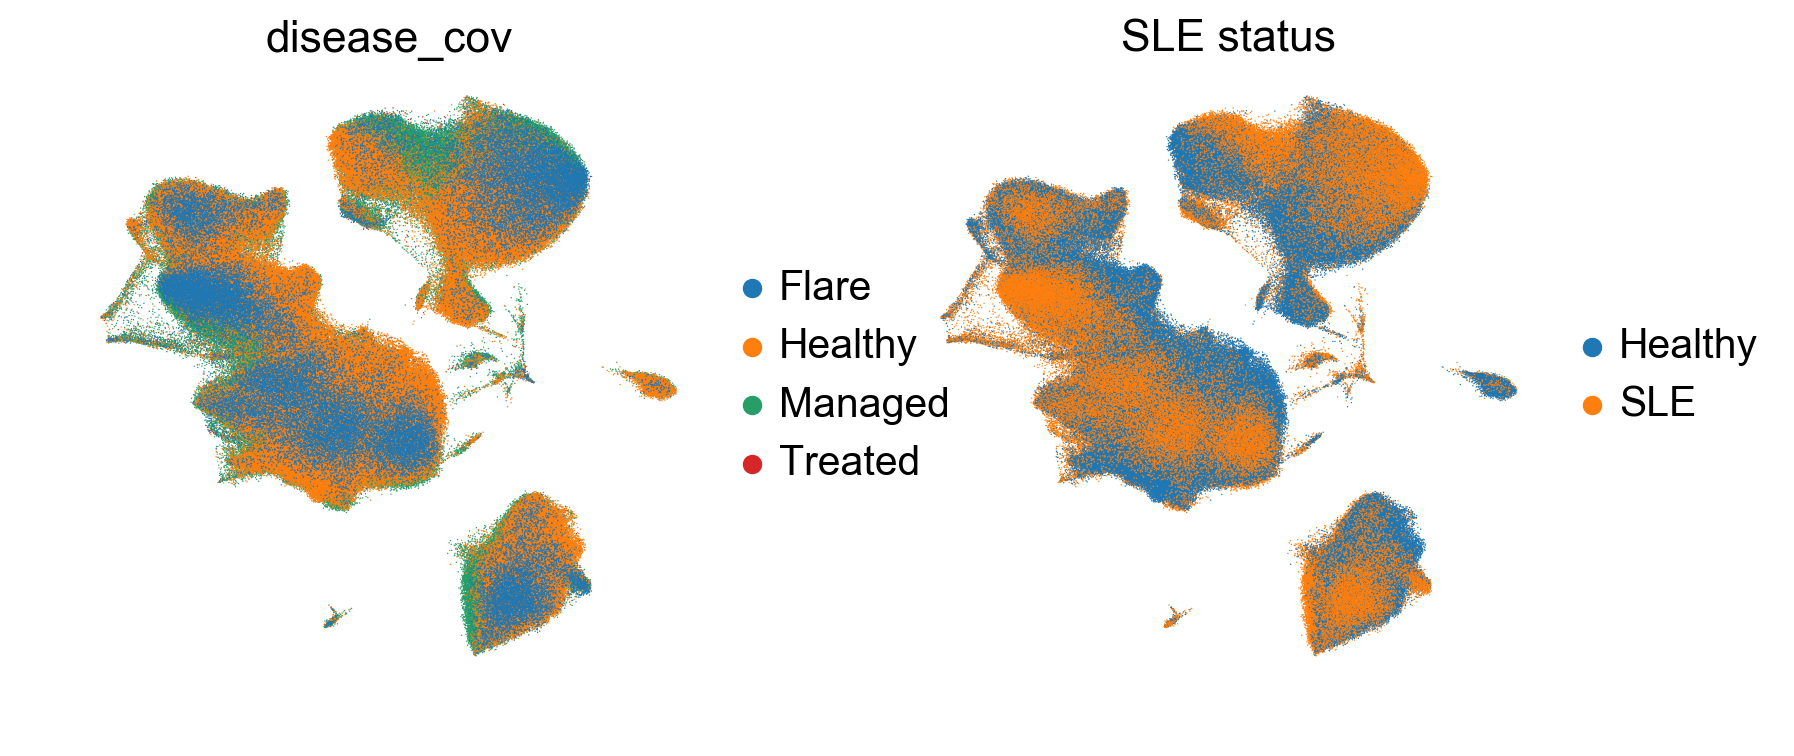

In [4]:
disease_umap = sc.pl.umap(adata, color=['disease_cov', 'SLE status'], size=1, show=True, edgecolor="none", palette=sc.pl.palettes.vega_20_scanpy, save='.disease.png')

In [ ]:
sc.tl.embedding_density(adata, basis='umap', groupby='disease_cov')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_disease_cov', show=True,  save='umap_density_disease_cov.png')

In [ ]:
sc.tl.embedding_density(adata, basis='umap', groupby='disease_cov')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_disease_cov', show=True,  save='umap_density_disease_cov.png')

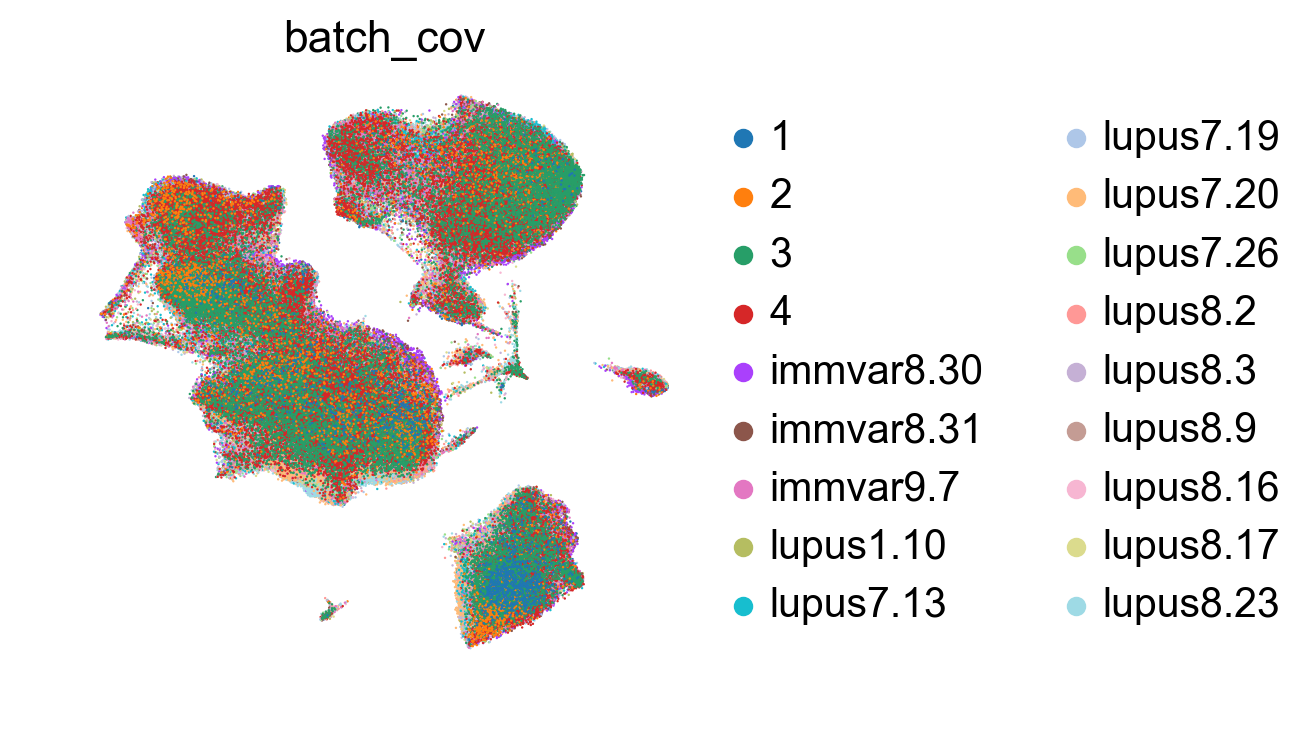

In [5]:
disease_umap = sc.pl.umap(adata, color='batch_cov', size=3,show=True, edgecolor="none", palette=sc.pl.palettes.vega_20_scanpy, save='.batch.png')

## Plot individual variability

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


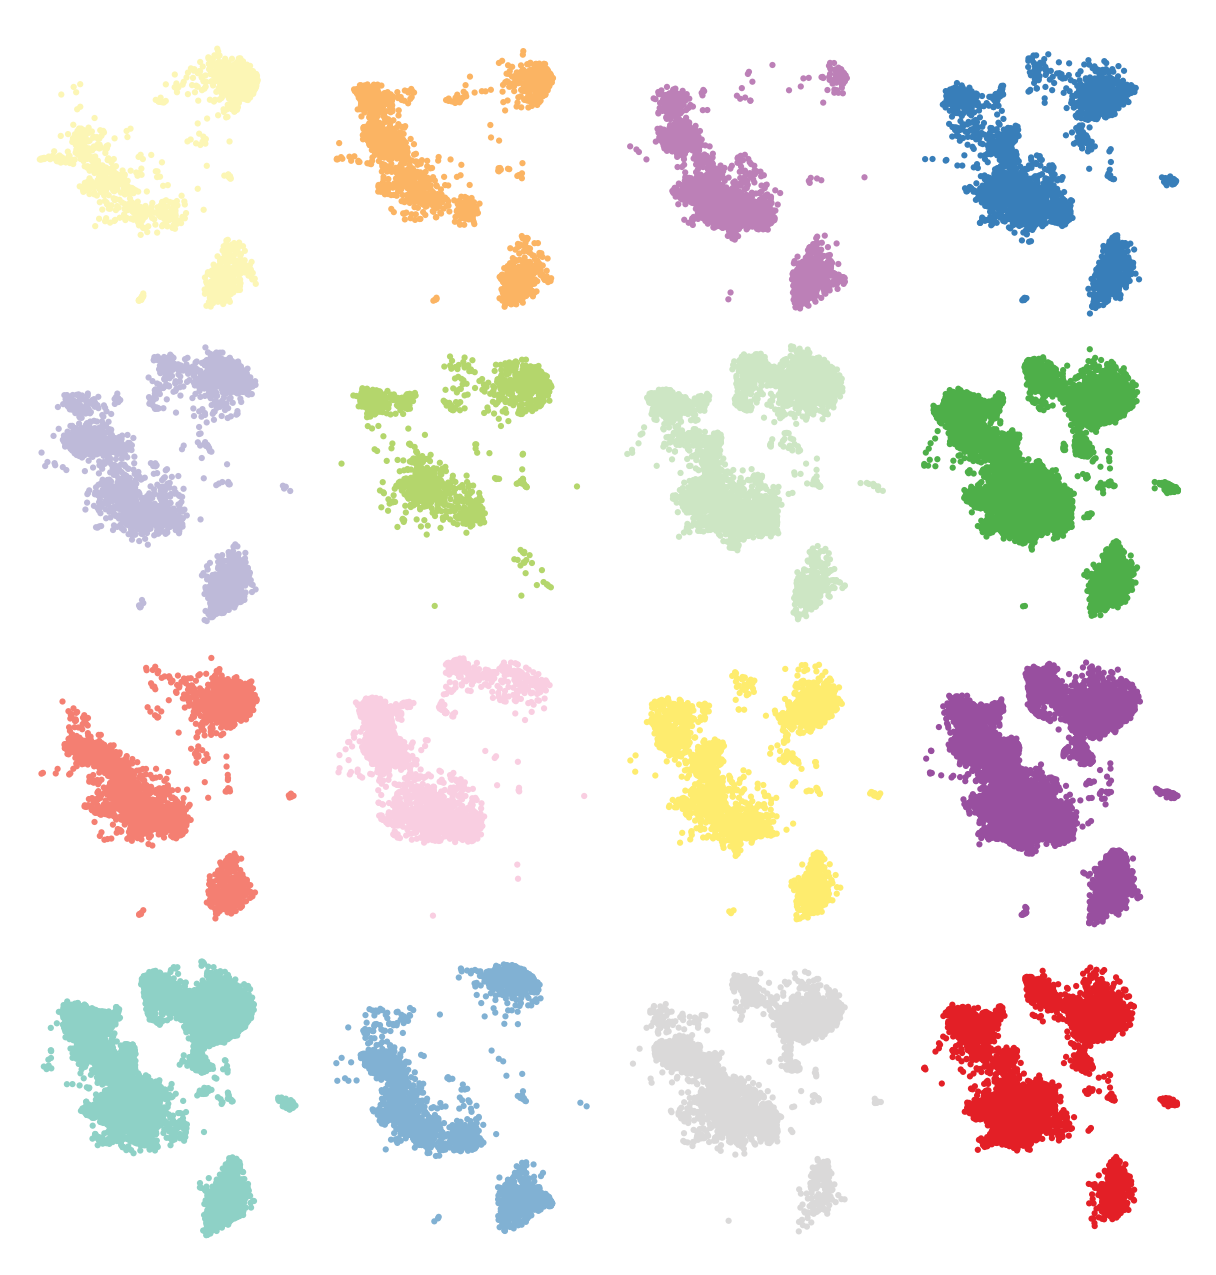

In [6]:
# Plot 16 plots for the individuals.
colors = ["#8ED1C6","#FCF6B5", "#BEBAD9", "#F47F72", "#81B1D3", "#FBB463", "#B4D66C", "#F9CEE1", "#DAD9D9", "#BC80B7", "#CDE6C4", "#FEEC6E", "#E31F26", "#387EB9", "#4EAF49", "#984F9F", "#8ED1C6","#FCF6B5", "#BEBAD9"];
fig,ax = plt.subplots(nrows=4,ncols=4, figsize=(7,7),sharex=True, sharey=True)
fig.tight_layout()
plt.subplots_adjust(wspace=-0.1, hspace=0)

batch_name = adata.obs.batch_cov.unique()[0]
batch = adata.obs.ind_cov_disease_cov[adata.obs.batch_cov==batch_name].unique();
batch = np.sort(batch.categories.values)
for ind_i in list(range(16)):
    ind = batch[ind_i]
    col = colors[ind_i]
    sc.pl.umap(adata[adata.obs.ind_cov_disease_cov==ind,], color = "ind_cov_disease_cov", title=None, palette=[col,col], ax=ax[(ind_i-1)%4,math.floor(ind_i/4)], size=20, edgecolor="none")
    ax[(ind_i-1)%4,math.floor(ind_i/4)].get_xaxis().set_visible(False)
    ax[(ind_i-1)%4,math.floor(ind_i/4)].get_yaxis().set_visible(False)
    ax[(ind_i-1)%4,math.floor(ind_i/4)].get_legend().remove()
    ax[(ind_i-1)%4,math.floor(ind_i/4)].set_title("")
    ax[(ind_i-1)%4,math.floor(ind_i/4)].set_aspect("equal")

fig.savefig(figdir+'/'+batch_name+'.ind.png')

# Rank genes and plot leiden groups

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test', n_genes=25)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

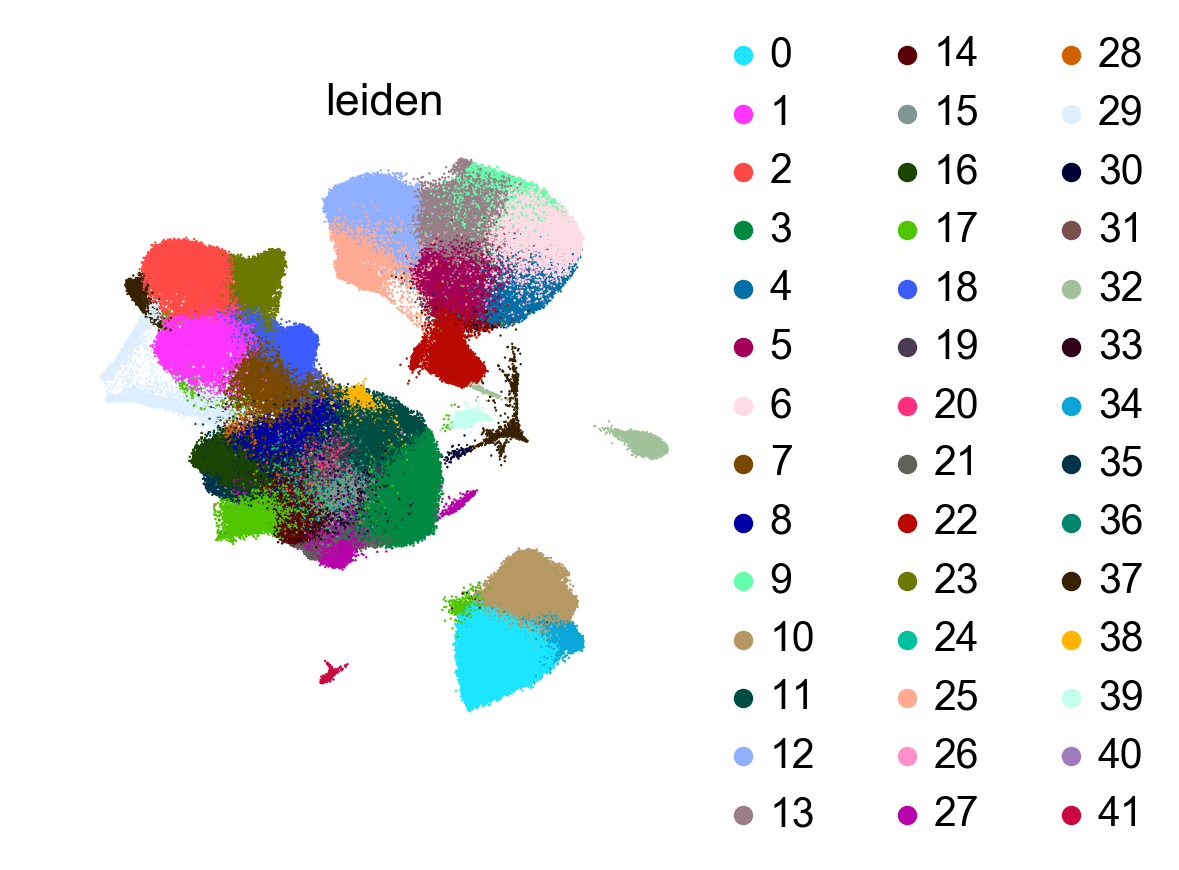

In [7]:
sc.pl.umap(adata, color='leiden', size=3, show=True, edgecolor="none", save='.leiden.png', palette=MASTERCOLORS)

# Most expressed genes per leiden group

In [8]:
pd.set_option('display.max_columns', None)
unique_leiden = np.unique(adata.obs['leiden'].values)
# Compile list of top genes
GeneRanks = pd.DataFrame()
for ii in range(len(unique_leiden)):
    GeneRanks[str('leiden_' + str(ii))] = adata.var_names[np.flipud(np.argsort(np.mean(adata.X[adata.obs['leiden'] == str(ii)], axis=0)))]
GeneRanks.to_csv('Flare_study_top_expression.csv')
GeneRanks.head(10)

,leiden_0,leiden_1,leiden_2,leiden_3,leiden_4,leiden_5,leiden_6,leiden_7,leiden_8,leiden_9,leiden_10,leiden_11,leiden_12,leiden_13,leiden_14,leiden_15,leiden_16,leiden_17,leiden_18,leiden_19,leiden_20,leiden_21,leiden_22,leiden_23,leiden_24,leiden_25,leiden_26,leiden_27,leiden_28,leiden_29,leiden_30,leiden_31,leiden_32,leiden_33,leiden_34,leiden_35,leiden_36,leiden_37,leiden_38,leiden_39,leiden_40,leiden_41
0,CD79A,GZMH,KLRF1,RP11-291B21.2,S100A12,LGALS2,S100A8,GZMK,TNFRSF4,IL1B,RP5-887A10.1,RPL21,CDKN1C,APOBEC3A,RPL21,RPL21,RTKN2,PF4,KLRB1,HIST1H1D,TSHZ2,RPS4Y1,FCER1A,XCL1,C1orf56,C1QA,MIR4435-1HG,SOX4,LINC00152,KIAA0101,HBA2,S100A9,LILRA4,STMN1,FCRL5,IFIT3,RNU12,HBA2,C1QA,CD9,CD1C,MZB1
1,TCL1A,CCL5,PRF1,CD8B,S100A8,LYZ,S100A9,CCL5,IL32,IL8,MS4A1,CCR7,FCGR3A,IFITM3,HLA-DQA1,CCR7,RP11-1399P15.1,TSC22D1,GZMK,CD69,PRKCQ-AS1,RPL21,CLEC10A,XCL2,CDC42SE1,C1QB,LINC00152,CHI3L2,MIR4435-1HG,STMN1,HBB,LYZ,SERPINF1,KIAA0101,MS4A1,IFIT1,LINC00910,HBA1,C1QB,TPM1,FCER1A,IGJ
2,MS4A1,NKG7,SPON2,S100B,S100A9,CTSS,S100A12,DUSP2,GATA3,G0S2,BANK1,PRKCQ-AS1,MS4A7,TYMP,FCER1A,PRKCQ-AS1,IL2RA,ACRBP,SLC4A10,TRAT1,LINC00861,EIF1AY,CD1C,KLRC1,RP11-138A9.2,FCGR3A,S100A9,ITM2A,IL32,MKI67,HBA1,S100A8,ITM2C,CENPF,CD79A,MX1,TMEM107,HBB,RPL21,GP1BA,CLEC10A,TNFRSF17
3,CD79B,FGFBP2,GZMB,CD8A,VCAN,FTL,VCAN,LYAR,KLRB1,S100A9,CD79A,LINC00861,HES4,ISG15,GPR183,TXK,TIGIT,RPL21,KLRG1,HIST1H1C,CCR7,TTTY15,HLA-DQA1,GNLY,APOBEC3C,MS4A7,S100A8,PRSS57,DUSP4,TYMS,RPL21,CTSS,PLD4,RPL21,HSPB1,ISG15,WDR74,ALAS2,IL32,GMPR,RPL21,DERL3
4,VPREB3,IL32,GNLY,RPL21,LYZ,GPX1,MNDA,CMC1,RORA,S100A8,AL928768.3,TXK,RP11-290F20.3,IFI6,CLEC10A,CD79A,ARID5B,RP11-367G6.3,DUSP2,HIST1H4C,GPR183,JUN,HLA-DPB1,CMC1,RPL21,LST1,LYZ,STMN1,GATA3,TK1,CCR7,CSTA,TPM2,CCR7,FCRL2,IFI6,RPPH1,HBD,CCR7,CLEC1B,CCR7,ITM2C
5,FCER2,CST7,FGFBP2,CCR7,CSTA,AIF1,LYZ,IL32,MAF,LYZ,AC079767.4,LBH,LST1,AIF1,CD1C,MS4A1,IKZF2,PPBP,NCR3,JUN,RPL21,DDX3Y,HLA-DQB1,KLRF1,PIP4K2A,HES4,S100A12,CYTL1,ARID5B,CENPF,PRKCQ-AS1,VCAN,LRRC26,MKI67,CD19,IFIT2,RPL21,CA1,PRKCQ-AS1,C19orf33,PRKCQ-AS1,IGLL5
6,RPL21,GZMA,CLIC3,LBH,MNDA,HLA-DRA,FCN1,PIK3R1,CD69,EREG,RALGPS2,GZMB,AIF1,FTL,HLA-DPA1,LINC00861,BIRC3,GNG11,CCL5,HIST1H1E,TRAT1,PRKCQ-AS1,HLA-DPA1,IL2RB,PRKCQ-AS1,AIF1,VCAN,RPL21,RGS1,NUSAP1,LBH,S100A6,SCT,PRKCQ-AS1,FCRL3,STAT1,RPS4Y1,FGFBP2,C1QC,LGALS12,BIRC3,AL928768.3
7,LINC00926,CD8A,NKG7,PRKCQ-AS1,GPX1,FTH1,CSTA,GZMA,TNFRSF18,S100A12,COBLL1,CD247,IFITM3,FCN1,PLD4,LBH,IL32,HIST1H2AC,LYAR,ZNF331,TXK,RNU12,CPVL,CTSW,CCR7,RP11-290F20.3,CSTA,CCR7,MIAT,BIRC5,STMN1,MNDA,IGJ,NUSAP1,FCRLA,SAMD9,EIF1AY,PRF1,LINC00861,FERMT3,TXK,HRASLS2
8,CD74,GNLY,KLRB1,TXK,CTSS,CPVL,RP11-1143G9.4,CD8B,LMNA,CCL3,CD79B,CD79A,RHOC,CTSS,HLA-DQB1,CD79B,RGS1,RGS18,GZMA,RPL21,TTN,CCR7,HLA-DRB1,SPTSSB,LINC00861,C1QC,GPX1,SPINK2,ALOX5AP,RRM2,TXK,S100A12,PPP1R14B,MS4A1,PPP1R14A,NT5C3A,SNORD3B-2,AHSP,CD8B,ESAM,LBH,CD38
9,RALGPS2,KLRG1,CST7,CTSW,FCN1,HLA-DRB1,CD14,CST7,CRIP1,FCN1,IGJ,PRF1,FCER1G,LGALS2,ITM2C,RALGPS2,CD27,SDPR,IL32,PRKCQ-AS1,ARID5B,WDR74,HLA-DRA,KLRD1,TXK,CDKN1C,CTSS,GATA2,SYNE2,TOP2A,LINC00861,FCN1,UGCG,HSPB1,HLA-DQA1,XAF1,DDX3Y,SPON2,CD69,TPM4,HLA-DOB,FKBP11


# Label cell populations

In [9]:
adata.obs['ct_cov'] = adata.obs['ct_cov'].astype('object')
adata.obs['ct_cov'].loc[adata.obs.leiden == "0"] = "B Cells" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "1"] = "Cytotoxic T Cells" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "2"] = "Natural Killer Cells" ## good                                                                                     
adata.obs['ct_cov'].loc[adata.obs.leiden == "3"] = "Naive T Cells" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "4"] = "Classical Monocytes" ## good    Effector Memory T Cells                                                                                 
adata.obs['ct_cov'].loc[adata.obs.leiden == "5"] = "Classical Monocytes" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "6"] = "Classical Monocytes" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "7"] = "Cytotoxic T Cells" ## good        Nonclassical Monocytes                                                                            
adata.obs['ct_cov'].loc[adata.obs.leiden == "8"] = "Effector Memory T Cells" ## good     Classical Dendritic Cells                                                                               
adata.obs['ct_cov'].loc[adata.obs.leiden == "9"] = "Classical Monocytes" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "10"] = "B Cells" ## good     Megakaryocytes                                                                             
adata.obs['ct_cov'].loc[adata.obs.leiden == "11"] = "Naive T Cells" ## good Plasmacytoid Dendritic Cells                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "12"] = "Nonclassical Monocytes" ## good                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "13"] = "Classical Monocytes" ## good  Macro    Proliferating T Cells                                                                             
adata.obs['ct_cov'].loc[adata.obs.leiden == "14"] = "Classical Dendritic Cells" ## good                                                                                  
adata.obs['ct_cov'].loc[adata.obs.leiden == "15"] = "Naive T Cells" ## good                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "16"] = "T-Reg T Cells" ## good                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "17"] = "Megakaryocytes" ## good                                                                                  
adata.obs['ct_cov'].loc[adata.obs.leiden == "18"] = "Cytotoxic T Cells" ## good  
adata.obs['ct_cov'].loc[adata.obs.leiden == "19"] = "Naive T Cells" ## good
adata.obs['ct_cov'].loc[adata.obs.leiden == "20"] = "Naive T Cells" ## good
adata.obs['ct_cov'].loc[adata.obs.leiden == "21"] = "Naive T Cells" ## good
adata.obs['ct_cov'].loc[adata.obs.leiden == "22"] = "Classical Dendritic Cells" ## good
adata.obs['ct_cov'].loc[adata.obs.leiden == "23"] = "Natural Killer Cells" ## good
adata.obs['ct_cov'].loc[adata.obs.leiden == "24"] = "Naive T Cells" ## good
adata.obs['ct_cov'].loc[adata.obs.leiden == "25"] = "Nonclassical Monocytes" ## good
adata.obs['ct_cov'].loc[adata.obs.leiden == "26"] = "Classical Monocytes" ## good
adata.obs['ct_cov'].loc[adata.obs.leiden == "27"] = "Progenitor Cells" ## good
adata.obs['ct_cov'].loc[adata.obs.leiden == "28"] = "Effector Memory T Cells" ## good
adata.obs['ct_cov'].loc[adata.obs.leiden == "29"] = "Proliferating T Cells" ## good
adata.obs['ct_cov'].loc[adata.obs.leiden == "30"] = "RBCs" ## good
adata.obs['ct_cov'].loc[adata.obs.leiden == "31"] = "Classical Monocytes" ## good
adata.obs['ct_cov'].loc[adata.obs.leiden == "32"] = "Plasmacytoid Dendritic Cells" ## good
adata.obs['ct_cov'].loc[adata.obs.leiden == "33"] = "Naive T Cells" ## good
adata.obs['ct_cov'].loc[adata.obs.leiden == "34"] = "B Cells" ## good
adata.obs['ct_cov'].loc[adata.obs.leiden == "35"] = "Naive T Cells" ## good
adata.obs['ct_cov'].loc[adata.obs.leiden == "36"] = "Naive T Cells" ## good
adata.obs['ct_cov'].loc[adata.obs.leiden == "37"] = "RBCs" ## good
adata.obs['ct_cov'].loc[adata.obs.leiden == "38"] = "Naive T Cells" ## good
adata.obs['ct_cov'].loc[adata.obs.leiden == "39"] = "Megakaryocytes" ## good
adata.obs['ct_cov'].loc[adata.obs.leiden == "40"] = "Naive T Cells" ## good
adata.obs['ct_cov'].loc[adata.obs.leiden == "41"] = "B Cells" ## good
adata.obs['ct_cov'] = adata.obs.ct_cov.astype('category')

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


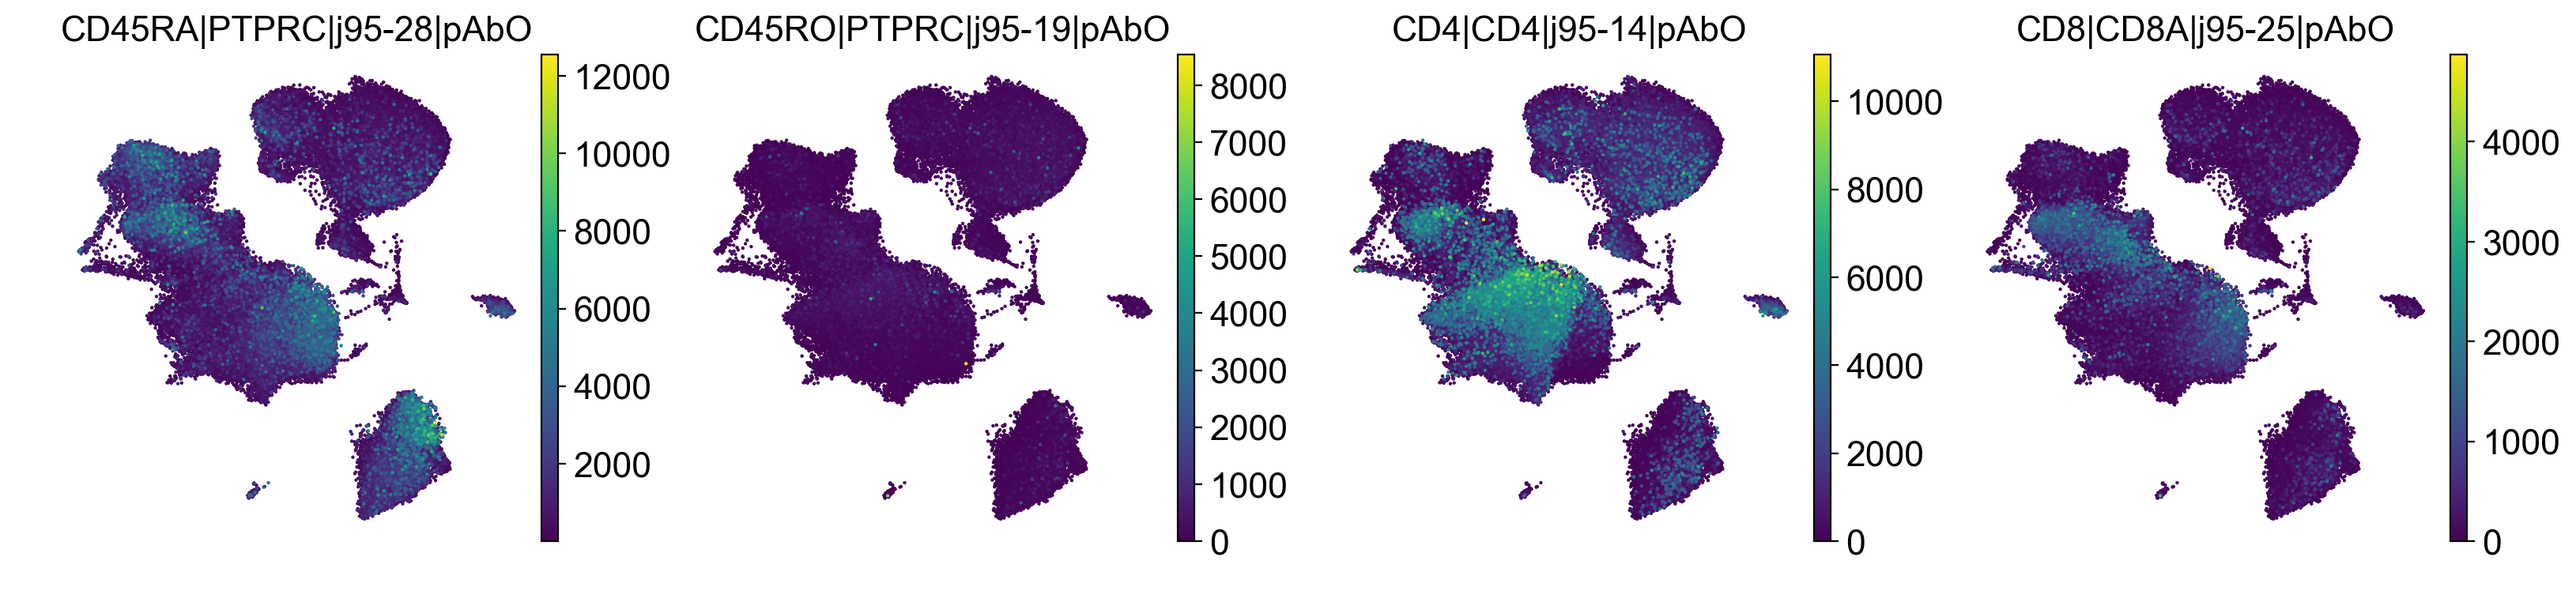

In [10]:
sc.pl.umap(adata, color=['CD45RA|PTPRC|j95-28|pAbO', 'CD45RO|PTPRC|j95-19|pAbO', 'CD4|CD4|j95-14|pAbO', 'CD8|CD8A|j95-25|pAbO'], size=10)

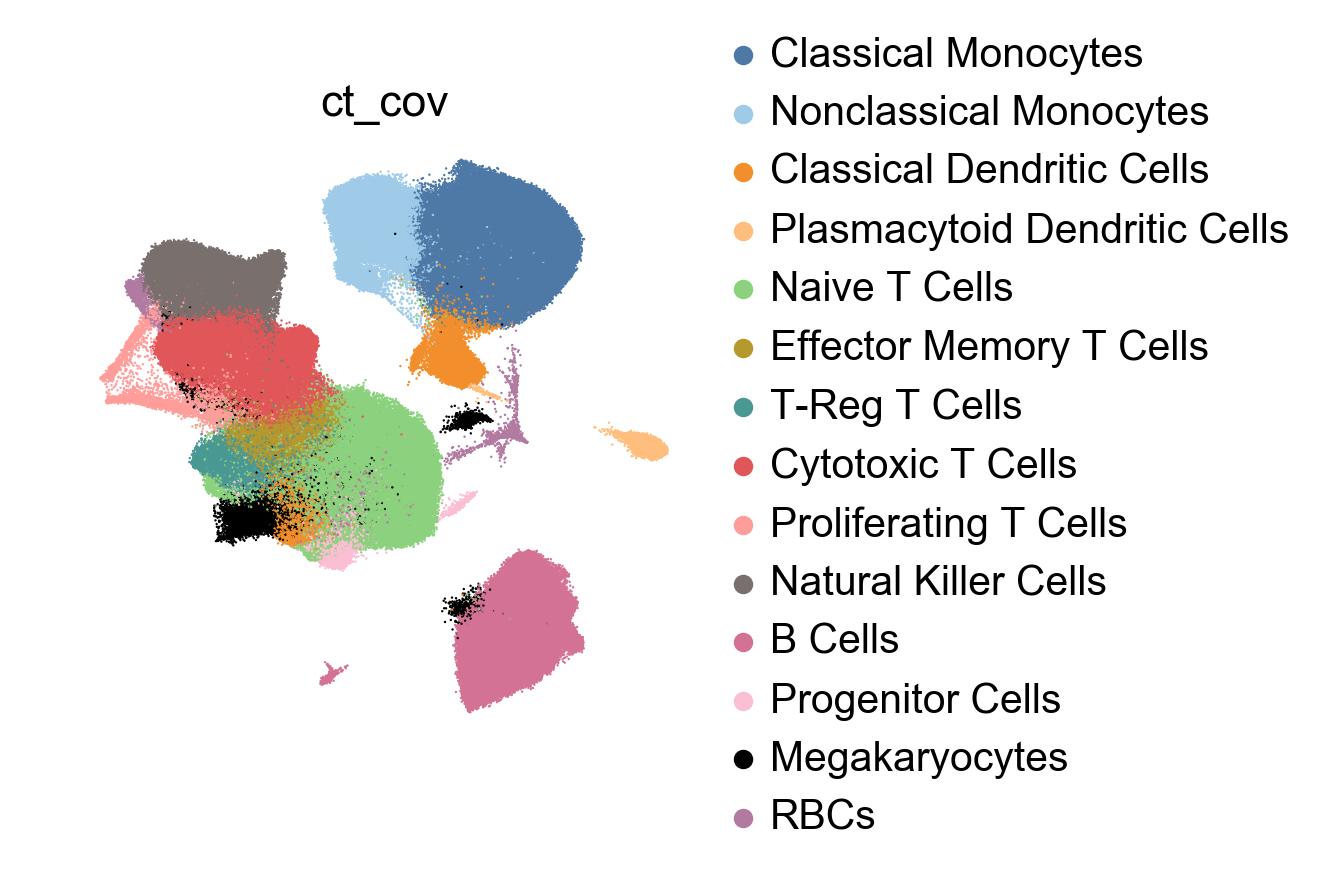

In [11]:
sc.settings.set_figure_params(dpi=100, dpi_save=300, format='png', frameon=False, transparent=True, fontsize=16)
plt.rcParams["image.aspect"] = "equal"
MasterORDER = ['Classical Monocytes','Nonclassical Monocytes', 'Classical Dendritic Cells', 'Plasmacytoid Dendritic Cells', 'Naive T Cells', 'Effector Memory T Cells','T-Reg T Cells', 'Cytotoxic T Cells', 'Proliferating T Cells', 'Natural Killer Cells', 'B Cells', 'Progenitor Cells', 'Megakaryocytes', 'RBCs']
#colorrs = ["#E58606","#5D69B1","#52BCA3","#99C945","#CC61B0","#24796C","#DAA51B","#2F8AC4","#764E9F","#ED645A","#CC3A8E",'#BC23FF', '#D790FF']
colorrs = ["#4E79A7","#A0CBE8","#F28E2B","#FFBE7D","#8CD17D","#B6992D","#499894","#E15759","#FF9D9A","#79706E","#D37295","#FABFD2", '#000000',"#B07AA1","#D4A6C8","#9D7660",
                 "#E58606", "#5D69B1", "#24796C", '#DAA51B', '#000000', '#99C945', '#ED645A']

adata.obs['ct_cov'] = adata.obs['ct_cov'].cat.reorder_categories(MasterORDER)
adata.uns['ct_cov_colors'] = colorrs
celltype_umap = sc.pl.umap(adata, color='ct_cov', show=True, size=3, edgecolor="none")

# Proportions and Statistics

In [ ]:
## Make proportion plots
adata_obs_small = adata.obs
ind_count = adata_obs_small.groupby(['ind_cov_disease_cov','ct_cov','disease_cov','pop_cov', 'ind_cov'])['ct_cov'].count()
ind_count_sums = ind_count.groupby(level=[0]).sum()
ind_count_sums = ind_count_sums.reset_index(name="counts")
ind_perc = ind_count/ind_count.groupby(level=[0]).transform(sum)*100
ind_perc = ind_perc.reset_index(name="ct_perc")
# Add weights to WLS
ind_perc['counts'] = ind_count.values.tolist()

ind_perc['ind_count_sum'] = list(np.zeros(len(ind_count.values.tolist()),dtype=int))
# Add total sums per individual to structure
for ii in range(len(ind_count_sums)):
    ind_perc['ind_count_sum'][ind_perc.ind_cov_disease_cov==ind_count_sums.ind_cov_disease_cov[ii]] = ind_count_sums.counts[ii]


ind_perc.ind_cov_disease_cov = ind_perc.ind_cov_disease_cov.apply(lambda x: x.split('_')[0])
ind_count_sums.ind_cov_disease_cov = ind_count_sums.ind_cov_disease_cov.apply(lambda x: x.split('_')[0])
#ind_perc = ind_perc.set_index('ct_cov').join(cg_cov.set_index('ct_cov'))
ind_perc.ind_cov_disease_cov = ind_perc.ind_cov_disease_cov.astype("str")
ind_perc.reset_index(inplace=True)
ind_perc.ct_cov = ind_perc.ct_cov.astype('category')
ind_perc.ct_cov = ind_perc.ct_cov.cat.reorder_categories(adata.obs.ct_cov.cat.categories.values)

perc_plot = sns.catplot(x='disease_cov', y='ct_perc', order=[ "Healthy", "Managed", "Treated", "Flare"], hue='ct_cov', data=ind_perc, kind='violin', col_order=MasterORDER, col='ct_cov', col_wrap=3, cut=0, dodge=False, aspect=1, sharex=False, sharey=False, palette=colorrs)

for ct_i in list(range(len(MasterORDER))):
    ct = MasterORDER[ct_i]
    sns.swarmplot(x="disease_cov", y="ct_perc", data=ind_perc[ind_perc.ct_cov == ct], order=[ "Healthy", "Managed", "Treated", "Flare"], color="0", size=4, ax=perc_plot.axes[ct_i])
    try:
        sns.pointplot(x="disease_cov", y="ct_perc", hue="ind_cov", data=ind_perc[ind_perc.ct_cov == ct], order=[ "Healthy", "Managed", "Treated", "Flare"], color="0", scale=0.3, ax=perc_plot.axes[ct_i])
    except:
        continue
    perc_plot.axes[ct_i].get_yaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_xaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_legend().remove()
    perc_plot.set_xticklabels(rotation=90)
    perc_plot.fig.subplots_adjust(wspace=2, hspace = 1)
    
perc_plot.savefig(figdir+"/violin.ct_cov_figure6b.png")
perc_plot.savefig(figdir+"/violin.ct_cov_figure6b.pdf")

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. Managed WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Managed'])]
HEALTHYMANAGED_effect = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Managed"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    HEALTHYMANAGED_effect[ct] = effect
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
display(all_out)

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. Treated WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Treated'])]
HEALTHYTREATED_effect = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Treated"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    HEALTHYTREATED_effect[ct] = effect
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
display(all_out)

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. Flare WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Flare'])]
HEALTHYFLARE_effect = {}
HEALTHYFLARE_FC = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Flare"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    HEALTHYFLARE_effect[ct] = effect
    HEALTHYFLARE_FC[ct] = math.log2(sum(est.params)/est.params[0])
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
display(all_out)

# Statistical tests...
print('as a proportion of total PBMC: Treated vs. Flare WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Treated', 'Flare'])]
TREATEDFLARE_effect = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Flare"] = 0
    disease.values[disease=="Treated"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    TREATEDFLARE_effect[ct] = effect
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
display(all_out)

# Statistical tests...
print('as a proportion of total PBMC: Treated vs. Managed WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Treated', 'Managed'])]
TREATEDMANAGED_effect = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Managed"] = 0
    disease.values[disease=="Treated"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    TREATEDMANAGED_effect[ct] = effect
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
display(all_out)

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. SLE WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Treated', 'Untreated', 'Managed'])]
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease!="Healthy"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
display(all_out)

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. Treated&Flare WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Treated', 'Untreated'])]
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease!="Healthy"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
display(all_out)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
def getproportions(celltype, group1, group2):
    print('{} proportion for celltype: {}: {}' .format(group1, celltype, ind_perc[ind_perc.disease_cov==group1][ind_perc.ct_cov==celltype].ct_perc.mean()))
    print('{} proportion for celltype: {}: {}' .format(group2, celltype, ind_perc[ind_perc.disease_cov==group2][ind_perc.ct_cov==celltype].ct_perc.mean()))

getproportions(celltype='Classical Monocytes',group1='Healthy', group2='Flare')

# Get differential gene expression for each cell population in psuedobulk

In [ ]:
def get_pseudobulk(adata):
    genes = adata.raw.var_names.tolist()
    people = np.unique(adata.obs['ind_cov'].tolist())
    pseudobulk = pd.DataFrame(index=genes, columns=people)
    for ii in range(len(people)):
        fdata = adata[adata.obs['ind_cov']==people[ii]]
        pseudobulk[people[ii]] = np.ravel(np.sum(fdata.raw.X, axis=0)/len(fdata))
    return pseudobulk

def compute_LogFC(pseudobulk, SLE_list, healthy_list):
    logFC = {}; pval  = {}
    genes = pseudobulk.transpose().keys().tolist()
    for ii in range(len(genes)):
        h = pseudobulk[healthy_people].transpose()[genes[ii]].values
        s = pseudobulk[SLE_people].transpose()[genes[ii]].values
        _, p = stats.ranksums(s,h)
        pval[genes[ii]] = p
        s = np.nanmean(s)
        h = np.nanmean(h)
        logFC[genes[ii]] = np.log2(np.divide(s+10**-3,h+10**-3))
    return logFC, pval

def make_volcanoplot(logFC, pval, title):
    num_std = 6 # Number of standard deviations above/below mean for gene log2 FC cutoff.
    pval_cutoff = 9 # 10^-n (0.001/~39000) allows for 1/1000 false alarm rate corrected for # genes
    s = np.std(np.asarray(list(logFC.values())))
    upper = np.mean(np.asarray(list(logFC.values()))) + (np.std(np.asarray(list(logFC.values())))*num_std)
    lower = np.mean(np.asarray(list(logFC.values()))) - (np.std(np.asarray(list(logFC.values())))*num_std)
    genes = np.asarray(list(logFC.keys()))
    x = np.asarray(list(logFC.values()))
    y = np.log10(list(pval.values()))*-1
    sc.settings.set_figure_params(dpi=200, dpi_save=300, format='png', frameon=False, transparent=True, fontsize=12)
    # Plot non-significant values
    sns.scatterplot(x[(x<=upper) & (x>=lower) & (y<=pval_cutoff)], y[(x<=upper) & (x>=lower) & (y<=pval_cutoff)], color=[0.5, 0.5, 0.5], alpha=0.2)
    sns.scatterplot(x[(x<upper) & (y>pval_cutoff)], y[(x<upper) & (y>pval_cutoff)], color=[0.5, 0.5, 0.5], alpha=0.2)
    sns.scatterplot(x[(x>lower) & (y>pval_cutoff)], y[(x>lower) & (y>pval_cutoff)], color=[0.5, 0.5, 0.5], alpha=0.2)
    # Plot significant values
    sns.scatterplot(x[(x>upper) & (y>pval_cutoff)], y[(x>upper) & (y>pval_cutoff)], color='#a1caf1')
    sns.scatterplot(x[(x<lower) & (y>pval_cutoff)], y[(x<lower) & (y>pval_cutoff)], color='#a1caf1')
    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-log10 p-value')
    plt.title('Volcano plot: {}'.format(title))
    for ii in range(len(genes[(x>upper) & (y>pval_cutoff)])):
        plt.text(x[(x>upper) & (y>pval_cutoff)][ii], y[(x>upper) & (y>pval_cutoff)][ii], s=genes[(x>upper) & (y>pval_cutoff)][ii], fontsize=5)

    for ii in range(len(genes[(x<lower) & (y>pval_cutoff)])):
        plt.text(x[(x<lower) & (y>pval_cutoff)][ii], y[(x<lower) & (y>pval_cutoff)][ii], s=genes[(x<lower) & (y>pval_cutoff)][ii], fontsize=5)
    URG = genes[(x>upper) & (y>pval_cutoff)]
    DRG = genes[(x<lower) & (y>pval_cutoff)]
    return URG, DRG
    

## Total PBMC psuedobulk log2 FC

In [ ]:
def get_totalPBMC_log2FC(adata):
    healthy_people = np.unique(adata.obs['ind_cov'][adata.obs['SLE status']=='Healthy'].tolist())
    SLE_people = np.unique(adata.obs['ind_cov'][adata.obs['SLE status']=='SLE'].tolist())
    pseudobulk_totalPBMC = get_pseudobulk(adata)
    logFC_totalPBMC, pval_totalPBMC = compute_LogFC(pseudobulk_totalPBMC, SLE_people, healthy_people)
    data = pd.DataFrame(list(logFC_totalPBMC.values()), index=list(logFC_totalPBMC.keys()), columns=['Log2FC'])
    data2 = pd.DataFrame(list(pval_totalPBMC.values()), index=list(pval_totalPBMC.keys()), columns=['p-value'])
    data = pd.concat([data, data2], axis=1)
    data = data.transpose()
    data.to_csv('Log2FC-SLEvsHealthy-totalPBMC.csv')
    return logFC_totalPBMC, pval_totalPBMC
logFC_totalPBMC, pval_totalPBMC = get_totalPBMC_log2FC(adata)

tmp = pd.read_csv('Log2FC-SLEvsHealthy-totalPBMC.csv')
logFC_totalPBMC = tmp.transpose()['Log2FC'].to_dict()
pval_totalPBMC = tmp.transpose()['p-value'].to_dict()

In [ ]:
URG_total, DRG_total = make_volcanoplot(logFC_totalPBMC, pval_totalPBMC, title='Total PBMCs')

# Log2 FC for each subpopulation

In [ ]:
def run_subpop_log2FC(adata):
    ct_groups = np.unique(adata.obs['ct_cov'].tolist())
    logFC_groups = {}; pval_groups = {};
    for ii in range(len(ct_groups)):
        print('Cell type: {}'.format(ct_groups[ii]))
        fdata = adata[adata.obs['ct_cov']==ct_groups[ii]]
        healthy_people = np.unique(fdata.obs['ind_cov'][fdata.obs['SLE status']=='Healthy'].tolist())
        SLE_people = np.unique(fdata.obs['ind_cov'][fdata.obs['SLE status']=='SLE'].tolist())
        pseudobulk = get_pseudobulk(fdata)
        logFC, pval = compute_LogFC(pseudobulk, SLE_people, healthy_people)
        logFC_groups[ct_groups[ii]] = logFC
        pval_groups[ct_groups[ii]] = pval
        data = pd.DataFrame(list(logFC_groups[ct_groups[ii]].values()), index=list(logFC_groups[ct_groups[ii]].keys()), columns=['Log2FC'])
        data2 = pd.DataFrame(list(pval_groups[ct_groups[ii]].values()), index=list(pval_groups[ct_groups[ii]].keys()), columns=['p-value'])
        data = pd.concat([data, data2], axis=1)
        data = data.transpose()
        data.to_csv('Log2FC-SLEvsHealthy-{}.csv'.format(ct_groups[ii]))
        
def get_subpop_log2FC(adata):
    ct_groups = np.unique(adata.obs['ct_cov'].tolist())
    logFC_groups = {}; pval_groups = {};
    for ii in range(len(ct_groups)):
        tmp = pd.read_csv('Log2FC-SLEvsHealthy-{}.csv'.format(ct_groups[ii]), index_col=0)
        logFC_groups[ct_groups[ii]] = tmp.transpose()['Log2FC'].to_dict()
        pval_groups[ct_groups[ii]] = tmp.transpose()['p-value'].to_dict()
    return logFC_groups, pval_groups
    
run_subpop_log2FC(adata)

#logFC_groups, pval_groups = get_subpop_log2FC(adata)

In [ ]:
URG = {}; DRG = {}; # Up and Down Regulated Genes for each population
ct_groups = np.unique(adata.obs['ct_cov'].tolist())
for ii in range(len(ct_groups)):
    plt.figure()
    URG[ct_groups[ii]], DRG[ct_groups[ii]] = make_volcanoplot(logFC_groups[ct_groups[ii]], pval_groups[ct_groups[ii]], ct_groups[ii])
    

# Compute Gene-Cell-Type specific expression per individual

# Make signatures for cell type specific expression without pan signature

In [ ]:
ct_groups = np.unique(adata.obs['ct_cov'].tolist())
URG_exclude = {}; DRG_exclude = {}
for ii in range(len(ct_groups)):
    listURG = list(URG[ct_groups[ii]])
    listDRG = list(DRG[ct_groups[ii]])
    removallist = list(set(URG[ct_groups[ii]]).intersection(URG_total))
    removallistD = list(set(DRG[ct_groups[ii]]).intersection(DRG_total))
    for item in removallist:
        listURG.remove(item)
    for item in removallistD:
        listDRG.remove(item)
    URG_exclude[ct_groups[ii]] = listURG
    DRG_exclude[ct_groups[ii]] = listDRG

# Compute averaged gene expression of significant genes per person 

In [ ]:
pseudobulk = get_pseudobulk(adata)
corr_matrix = pd.DataFrame(index=list(pseudobulk.columns))
corr_matrix['URG-totalPBMC'] = pseudobulk.transpose()[URG_total].mean(axis=1).values
corr_matrix['DRG-totalPBMC'] = pseudobulk.transpose()[DRG_total].mean(axis=1).values


ct_groups = np.unique(adata.obs['ct_cov'].tolist())
for ii in range(len(ct_groups)):
    try:
        print('Cell type: {}'.format(ct_groups[ii]))
        fdata = adata[adata.obs['ct_cov']==ct_groups[ii]]
        pseudobulk = get_pseudobulk(fdata)
        #corr_matrix['URG-{}'.format(ct_groups[ii])] = pseudobulk.transpose()[URG[ct_groups[ii]]].mean(axis=1).values
        #corr_matrix['DRG-{}'.format(ct_groups[ii])] = pseudobulk.transpose()[DRG[ct_groups[ii]]].mean(axis=1).values
        corr_matrix['URG-{}'.format(ct_groups[ii])] = pseudobulk.transpose()[URG_exclude[ct_groups[ii]]].mean(axis=1).values
        corr_matrix['DRG-{}'.format(ct_groups[ii])] = pseudobulk.transpose()[DRG_exclude[ct_groups[ii]]].mean(axis=1).values
    except:
        continue
corr_matrix.to_csv('Expression-Composition-corrmatrix.csv')


In [ ]:
corr_matrix = pd.read_csv('Expression-Composition-corrmatrix.csv', index_col=0)

# Compute composition of each cell type per person

In [ ]:
## Make proportion plots
adata_obs_small = adata.obs
ind_count = adata_obs_small.groupby(['ind_cov', 'ct_cov','SLE status'])['ct_cov'].count()
ind_count_sums = ind_count.groupby(level=[0]).sum()
ind_count_sums = ind_count_sums.reset_index(name="counts")
ind_perc = ind_count/ind_count.groupby(level=[0]).transform(sum)*100
ind_perc = ind_perc.reset_index(name="ct_perc")


In [ ]:
# Add composition changes
people = corr_matrix.index.tolist()
ct_groups = np.unique(adata.obs['ct_cov'].tolist())
for jj in range(len(ct_groups)):
    tmp = ind_perc[ind_perc['ct_cov']==ct_groups[jj]]
    tmplist = np.empty((len(people),))
    tmplist[:] = np.nan
    for ii in range(len(people)):
        try:
            tmplist[ii] = tmp[tmp['ind_cov']==people[ii]]['ct_perc'].values[0]
        except:
            continue
    corr_matrix['Proportion-{}'.format(ct_groups[jj])] = tmplist
# Remove empty categories    
labels = list(corr_matrix.columns)
for lbl in labels:
    if np.sum(np.isnan(corr_matrix[lbl]))==len(corr_matrix):
        print('Removing category: {} due to lack of data.'.format(lbl))
        corr_matrix = corr_matrix.drop(lbl, axis='columns')

In [ ]:
pd.set_option('display.max_columns', None)
display(corr_matrix)

# Compute correlations between URG, DRGs and cell type composition

In [ ]:
correlations = corr_matrix.corr(method='spearman')
correlations[np.isnan(correlations)] = 0
sns.set(font_scale=0.5)
sns.clustermap(np.abs(correlations))
plt.savefig("Correlation_plot.png", pad_inches=10, bbox_inches='tight')

In [ ]:
sc.settings.set_figure_params(dpi=150, dpi_save=200, format='png', frameon=False, transparent=True, fontsize=5)
x = np.asarray(list((correlations['URG-totalPBMC'].values)))
indices = np.flipud(np.argsort(x))
x = x[indices]
y = np.asarray(list(correlations['URG-totalPBMC'].index))
y = y[indices]
g = sns.barplot(x, y)
plt.title('Correlations to URG-totalPBMC gene signature')

In [ ]:
sc.settings.set_figure_params(dpi=150, dpi_save=200, format='png', frameon=False, transparent=True, fontsize=5)
x = np.asarray(list((correlations['Proportion-Naive T Cells'].values)))
indices = np.flipud(np.argsort(x))
x = x[indices]
y = np.asarray(list(correlations['Proportion-Naive T Cells'].index))
y = y[indices]
g = sns.barplot(x, y)
plt.title('Correlations to Naive T cell composition')

In [ ]:
sc.settings.set_figure_params(dpi=150, dpi_save=200, format='png', frameon=False, transparent=True, fontsize=5)
x = np.asarray(list((correlations['Proportion-Plasmacytoid Dendritic Cells'].values)))
indices = np.flipud(np.argsort(x))
x = x[indices]
y = np.asarray(list(correlations['Proportion-Plasmacytoid Dendritic Cells'].index))
y = y[indices]
g = sns.barplot(x, y)
plt.title('Correlations to Plasmacytoid Dendritic Cells composition')

In [ ]:
sc.settings.set_figure_params(dpi=150, dpi_save=200, format='png', frameon=False, transparent=True, fontsize=5)
x = np.asarray(list((correlations['Proportion-Classical Dendritic Cells'].values)))
indices = np.flipud(np.argsort(x))
x = x[indices]
y = np.asarray(list(correlations['Proportion-Classical Dendritic Cells'].index))
y = y[indices]
g = sns.barplot(x, y)
plt.title('Correlations to Classical Dendritic Cells composition')

In [ ]:
sc.settings.set_figure_params(dpi=150, dpi_save=200, format='png', frameon=False, transparent=True, fontsize=5)
x = np.asarray(list((correlations['Proportion-Classical Monocytes'].values)))
indices = np.flipud(np.argsort(x))
x = x[indices]
y = np.asarray(list(correlations['Proportion-Classical Monocytes'].index))
y = y[indices]
g = sns.barplot(x, y)
plt.title('Correlations to Classical Monocytes composition')

In [ ]:
sc.settings.set_figure_params(dpi=150, dpi_save=200, format='png', frameon=False, transparent=True, fontsize=5)
x = np.asarray(list((correlations['Proportion-Cytotoxic T Cells'].values)))
indices = np.flipud(np.argsort(x))
x = x[indices]
y = np.asarray(list(correlations['Proportion-Cytotoxic T Cells'].index))
y = y[indices]
g = sns.barplot(x, y)
plt.title('Correlations to Cytotoxic T Cells composition')

# Clinical covariate analysis

In [ ]:
clincal = pd.read_csv('lupus.sledai.txt', sep='\t')
display(clincal)

# Remove SLE patient that have no clinical data

In [ ]:
corr_matrix_mod = corr_matrix[~corr_matrix.transpose().columns.isin(['FLARE002', 'FLARE004', 'FLARE005', 'FLARE006', 
                                                                     'FLARE007', 'FLARE009','FLARE011', 'FLARE013', 
                                                                     'FLARE014', 'FLARE015', 'FLARE016','FLARE017', 
                                                                     'FLARE018', 'FLARE019', 'FLARE020'])]

In [ ]:
def build_covar(corr_matrix_mod, key):
    clincal = pd.read_csv('lupus.sledai.txt', sep='\t')
    inds = list(corr_matrix_mod.transpose().columns)
    covar = {}
    for ii in range(len(inds)):
        if np.sum(clincal['genotypeid'].isin([inds[ii]]).values):
            covar[inds[ii]] = clincal[clincal['genotypeid'].isin([inds[ii]]).values][key].values[0]
        else:
            covar[inds[ii]] = 0
    corr_matrix_mod[key] = list(covar.values())
    return corr_matrix_mod

In [ ]:
corr_matrix_mod = build_covar(corr_matrix_mod, 'SLAQ score')
corr_matrix_mod = build_covar(corr_matrix_mod, 'sleactivity')
corr_matrix_mod = build_covar(corr_matrix_mod, 'SLIC score')
corr_matrix_mod = build_covar(corr_matrix_mod, 'acrcsum')
corr_matrix_mod = build_covar(corr_matrix_mod, 'sledaiscore')

In [ ]:
display(corr_matrix_mod)

In [ ]:
correlations = corr_matrix_mod.corr(method='spearman')
correlations[np.isnan(correlations)] = 0
sns.set(font_scale=0.5)
sns.clustermap(np.abs(correlations))
plt.savefig("Correlation+clinical_plot.png", pad_inches=10, bbox_inches='tight')

In [ ]:
sc.settings.set_figure_params(dpi=150, dpi_save=200, format='png', frameon=False, transparent=True, fontsize=5)
x = np.asarray(list((correlations['kidney'].values)))
indices = np.flipud(np.argsort(x))
x = x[indices]
y = np.asarray(list(correlations['kidney'].index))
y = y[indices]
g = sns.barplot(x, y)
plt.title('Correlations to kidney')

In [ ]:
sc.settings.set_figure_params(dpi=150, dpi_save=200, format='png', frameon=False, transparent=True, fontsize=5)
x = np.asarray(list((correlations['SLAQ score'].values)))
indices = np.flipud(np.argsort(x))
x = x[indices]
y = np.asarray(list(correlations['SLAQ score'].index))
y = y[indices]
g = sns.barplot(x, y)
plt.title('Correlations to SLAQ score')

In [ ]:
sc.settings.set_figure_params(dpi=150, dpi_save=200, format='png', frameon=False, transparent=True, fontsize=5)
x = np.asarray(list((correlations['sleactivity'].values)))
indices = np.flipud(np.argsort(x))
x = x[indices]
y = np.asarray(list(correlations['sleactivity'].index))
y = y[indices]
g = sns.barplot(x, y)
plt.title('Correlations to sleactivity')

In [ ]:
sc.settings.set_figure_params(dpi=150, dpi_save=200, format='png', frameon=False, transparent=True, fontsize=5)
x = np.asarray(list((correlations['SLIC score'].values)))
indices = np.flipud(np.argsort(x))
x = x[indices]
y = np.asarray(list(correlations['SLIC score'].index))
y = y[indices]
g = sns.barplot(x, y)
plt.title('Correlations to SLIC score')

In [ ]:
sc.settings.set_figure_params(dpi=150, dpi_save=200, format='png', frameon=False, transparent=True, fontsize=5)
x = np.asarray(list((correlations['sledaiscore'].values)))
indices = np.flipud(np.argsort(x))
x = x[indices]
y = np.asarray(list(correlations['sledaiscore'].index))
y = y[indices]
g = sns.barplot(x, y)
plt.title('Correlations to sledaiscore')

In [ ]:
sc.settings.set_figure_params(dpi=150, dpi_save=200, format='png', frameon=False, transparent=True, fontsize=5)
x = np.asarray(list((correlations['acrcsum'].values)))
indices = np.flipud(np.argsort(x))
x = x[indices]
y = np.asarray(list(correlations['acrcsum'].index))
y = y[indices]
g = sns.barplot(x, y)
plt.title('Correlations to acrcsum')

In [ ]:
sc.pl.heatmap(adata, groupby='ct_cov', var_names=newlist, dendrogram=True, log=True, standard_scale='var', swap_axes=True)


# Feature plots for Untreated Treated pairs

In [ ]:
%%capture
pairs = ['FLARE004', 'FLARE009', 'FLARE011', 'FLARE013', 'FLARE016', 'FLARE003', 'FLARE002', 'FLARE008']
colors = ["#000000", "#FF0000"]
for pair in pairs:
    bdata = adata[adata.obs['ind_cov']==pair]
    print(pair)
    sc.pl.umap(bdata, size=10, show=True, color='disease_cov', save=str('TREATED_UNTREATED_PAIR'+ pair + '.disease.png'), palette=colors)
    plt.show() 

# Map colors onto cell type labels

In [ ]:
colormapping = dict()
unique_ct = adata.obs.ct_cov.cat.categories.tolist()
for ii in range(len(unique_ct)):
    colormapping[unique_ct[ii]] = adata.uns['ct_cov_colors'][ii]

# Feature plots for marker genes

In [ ]:
# Atypical memory B cells
sc.pl.umap(adata, color=['CR2', 'CD27', 'FCRL5', 'ITGAX', 'NKG7'], show=False, save='.AtypicalBgenes.png')

In [ ]:
## platelet effect
sc.pl.umap(adata, color=["PF4", "SDPR", "GNG11", "PPBP"], size=3, show=False, save='.platelet.png')

In [ ]:
## cycling
sc.pl.umap(adata, color=["KIAA0101","STMN1","TK1","MKI67"], size=3, show=False, save='.cycling.png')

In [ ]:
## MACROPHAGES
sc.pl.umap(adata, color=['CD163', 'HLA-DRB1', 'C1QA', 'IFITM3'], size=3, show=False, save=".MACRO.png")

In [ ]:
## CD4, CD8 and NK axis
sc.pl.umap(adata, color=["CD3D","CD8A","CD4","NCAM1", "FCGR3A", 'NKG7', 'IFNG', 'GZMB', 'PRF1'],size=3, show=True, save=".TNK.png")
# Two NK sub populations: CD56high/lowCD16high/low, CD56lowCD16high
# https://www.frontiersin.org/files/Articles/162361/fimmu-06-00567-HTML/image_m/fimmu-06-00567-g001.jpg

In [ ]:
## Memory vs. helper vs. naive
sc.pl.umap(adata, color=["CCR7","IL7R","S100A4","CD58", 'FAS', 'IL2RA'],show=False, size=3, save=".TMemThTNaive.png")

In [ ]:
## treg
sc.pl.umap(adata, color=["FOXP3","TNFRSF4","ENTPD1","CCR10"],size=3, show=False, save=".TREG.png")

In [ ]:
## y chromosome gender effect
sc.pl.umap(adata, color=["DDX3Y", "RPS4Y1", "FHIT","TRAT1"], size =3, show=False, save=".Y.png")

In [ ]:
## b cells, plasmablasts and pdcs
sc.pl.umap(adata, color=['BTLA', 'P2RY8',"MZB1", "CD19", "CD79A", 'MS4A1', 'FCRL5', 'IL6', 'CR2'],size=3, show=False, save=".B.png")


In [ ]:
sc.pl.umap(adata, color=['ITGAM', 'CD33', 'FUT4', 'HLA-DRA', 'CD14', 'CD163'],size=3, show=False, save=".B.png")

# Gene Ontology analysis for each cell type

In [ ]:
from __future__ import print_function
from Bio import Entrez
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.test_data.genes_NCBI_9606_ProteinCoding import GENEID2NT as GeneID2nt_hsa
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
from goatools.godag_plot import plot_gos, plot_results, plot_goid2goobj
# Store gene summaries
summary_dict = {}
def getgeneids(gene_list):
    Entrez.email = "richard.perez@ucsf.edu"
    # Store symbol and id
    geneid2symbol = {}
    for genesymbol in gene_list:
        try:
            handle = Entrez.esearch(db="gene", term=str(genesymbol + "[GENE] AND Homo"))
            record = Entrez.read(handle)
            geneid2symbol[int(record['IdList'][0])] = genesymbol
            handle.close()
        except:
            continue
    return geneid2symbol

def id2symbol(GENES, celltypes, cdata):
    for geneID in GENES:
        Entrez.email = "richard.perez@ucsf.edu"
        id_list= [str(geneID)]
        request = Entrez.epost("gene",id=",".join(id_list))
        result = Entrez.read(request)
        webEnv = result["WebEnv"]
        queryKey = result["QueryKey"]
        data = Entrez.esummary(db="gene", webenv=webEnv, query_key=queryKey)
        annotations = Entrez.read(data)
        symbol  = annotations['DocumentSummarySet']['DocumentSummary'][0]['Name']
        summary = annotations['DocumentSummarySet']['DocumentSummary'][0]['Summary']
        print(symbol)
        print(summary)
        ind_perc = plot_gene_expression(cdata, celltypes, symbol)
    return symbol, summary

def id2symbolfast(gene_id):
    Entrez.email = "richard.perez@ucsf.edu"
    id_list= [str(gene_id)]
    request = Entrez.epost("gene",id=",".join(id_list))
    result = Entrez.read(request)
    webEnv = result["WebEnv"]
    queryKey = result["QueryKey"]
    data = Entrez.esummary(db="gene", webenv=webEnv, query_key=queryKey)
    annotations = Entrez.read(data)
    symbol  = annotations['DocumentSummarySet']['DocumentSummary'][0]['Name']
    summary = annotations['DocumentSummarySet']['DocumentSummary'][0]['Summary']
    return symbol, summary

def replace_id_with_symbol(results, summary_dict):
    for ll in range(len(results['study_items'])):
        study_item = np.asarray(results['study_items'][ll].split(','), dtype=int)
        # Keep all gene summaries
        for ii in range(len(study_item)):
            symbol, summary = id2symbolfast(study_item[ii])
            summary_dict[symbol] = summary
        # Replace gene ID with gene symbol
        study_item = [id2symbolfast(study_item[ii])[0] for ii in range(len(study_item))]
        results['study_items'][ll]= study_item
    return results, summary_dict

def run_GO(gene_list, cutoff, title):
    obo_fname = download_go_basic_obo()
    fin_gene2go = download_ncbi_associations()
    obodag = GODag("go-basic.obo")

    # Read NCBI's gene2go. Store annotations in a list of namedtuples
    objanno = Gene2GoReader(fin_gene2go, taxids=[9606])

    # Get namespace2association where:
    #    namespace is:
    #        BP: biological_process               
    #        MF: molecular_function
    #        CC: cellular_component
    #    assocation is a dict:
    #        key: NCBI GeneID
    #        value: A set of GO IDs associated with that gene
    ns2assoc = objanno.get_ns2assc()

    for nspc, id2gos in ns2assoc.items():
        print("{NS} {N:,} annotated human genes".format(NS=nspc, N=len(id2gos)))

    goeaobj = GOEnrichmentStudyNS(
            GeneID2nt_hsa.keys(), # List of human protein-coding genes
            ns2assoc, # geneid/GO associations
            obodag, # Ontologies
            propagate_counts = False,
            alpha = cutoff, # default significance cut-off
            methods = ['fdr_bh']) # defult multipletest correction method

    geneid2symbol = getgeneids(gene_list)
    # 'p_' means "pvalue". 'fdr_bh' is the multiple test method
    geneids_study = geneid2symbol.keys()
    goea_results_all = goeaobj.run_study(geneids_study)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < cutoff]
    '''
    This plot contains GOEA results:

    GO terms colored by P-value:
    pval < 0.005 (light red)
    pval < 0.01 (light orange)
    pval < 0.05 (yellow)
    pval > 0.05 (grey) Study terms that are not statistically significant
    GO terms with study gene counts printed. e.g., "32 genes"
    '''
    plot_results(title+"{NS}.png", goea_results_sig, id2symbol=geneid2symbol, study_items=20, items_p_line=5)
    goeaobj.wr_xlsx(title+".xlsx", goea_results_sig, id2symbol=geneid2symbol)
    return geneid2symbol, goea_results_sig

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
ct_groups = np.unique(adata.obs['ct_cov'].tolist())
for ii in range(len(ct_groups)):
    try:
        ddata = adata[adata.obs['ct_cov']==ct_groups[ii]]
        sc.tl.rank_genes_groups(ddata, groupby='SLE status',groups=['Healthy', 'SLE'], reference='Healthy', n_genes=len(ddata.raw.var_names))
        sc.pl.rank_genes_groups(ddata, n_genes=25, save='{}_SLEvsHealthy.png'.format(ct_groups[ii]))
        genes = pd.DataFrame(ddata.uns['rank_genes_groups']['names'])
        scores = pd.DataFrame(ddata.uns['rank_genes_groups']['scores'])
        gene_list = list(np.ravel(genes[scores.values>(scores.mean()+(scores.std()*3))[0]].values.tolist()))
        cutoff = 0.001
        title = str(ct_groups[ii])+'_Lupus_Study'
        gene_list = list(np.ravel(genes[scores.values>(scores.mean()+(scores.std()*3))[0]].values.tolist()))
        run_GO(gene_list,cutoff,title)
        results = pd.read_excel(title+".xlsx")
        results, summary_dict = replace_id_with_symbol(results, summary_dict)
        print(ct_groups[ii])
        print('Number of genes 3 standard deviations above mean: {}'.format(np.sum(scores.values>(scores.mean()+(scores.std()*3))[0])))
        display(results)
    except:
        continue